# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # решающее дерево
from sklearn.ensemble import RandomForestClassifier # случаный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier # модель для проверки адекватности
from sklearn import tree

In [2]:
if os.path.exists('/datasets/users_behavior.csv'):
    df = pd.read_csv('/datasets/users_behavior.csv')
else:
    df = pd.read_csv('users_behavior.csv')
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


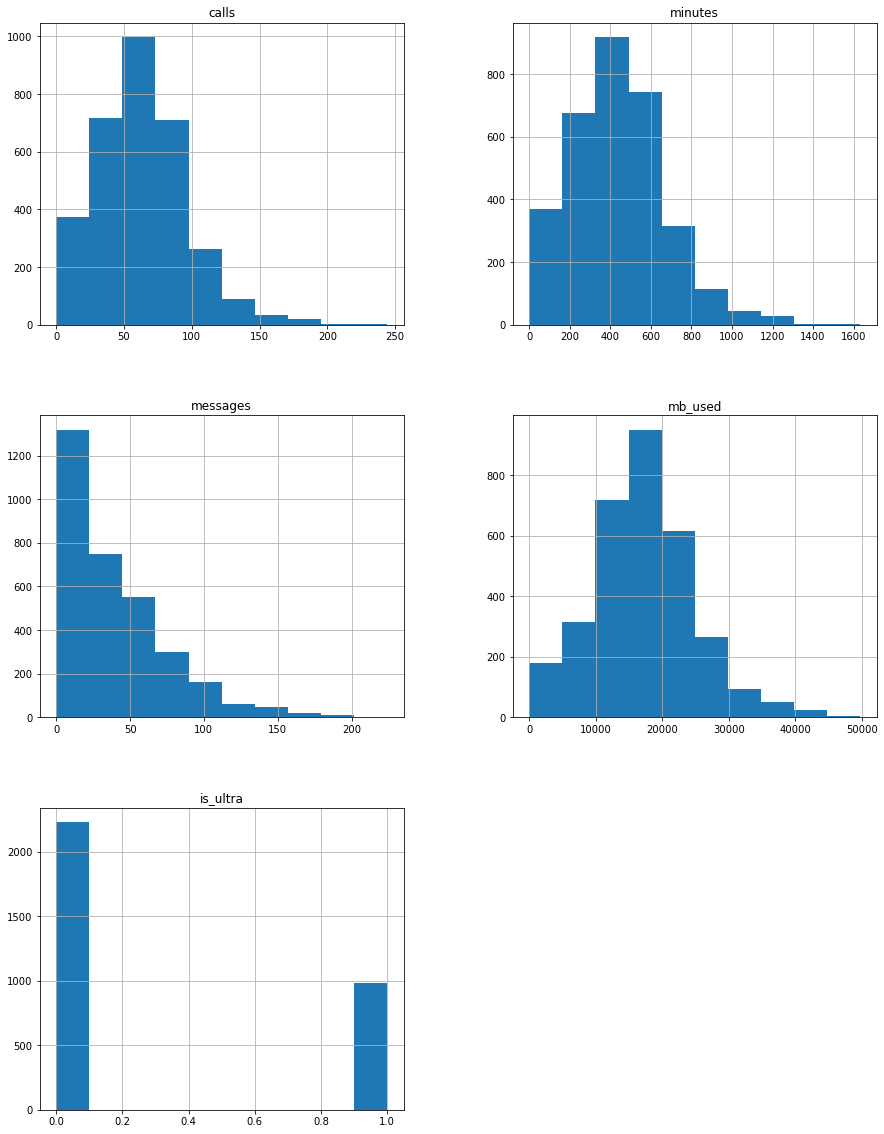

In [4]:
df.hist(figsize=(15, 20));

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


В данных отсутствуют пропуски. Медианное значение количества звонков - 62 в месяц, медианная длительность - 430 минут в месяц (более 7ч). Мединное количество сообщений - 30 сообщений в месяц, а использованных мегабайт интернета - 16 943 Мб (~ 16,5 Гб). Тех, кто пользуется тарифом ультра, более чем в два раза меньше пользователей тарифа Смарт.

## Разбейте данные на выборки

Отводим 60% данных под обучающую выборку и по 20% под валидационную и тестовую выборки. При делении на выборки учитываем дисбаланс в данных.

In [6]:
df_train, df_test_common = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra'])
df_test, df_valid = train_test_split(df_test_common, test_size=0.5, random_state=12345, stratify=df_test_common['is_ultra'])

Проверяем верность разбиения.

In [7]:
round(df_train.shape[0] / df.shape[0] * 100)

60

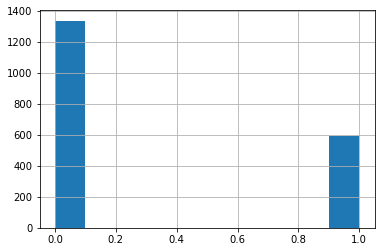

In [8]:
df_train['is_ultra'].hist();

In [9]:
round(df_test.shape[0] / df.shape[0] * 100)

20

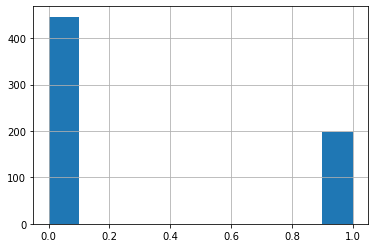

In [10]:
df_test['is_ultra'].hist();

In [11]:
round(df_valid.shape[0] / df.shape[0] * 100)

20

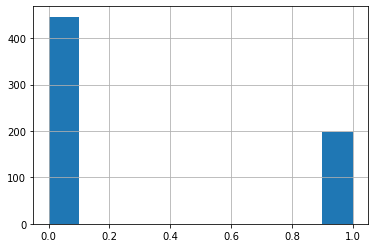

In [12]:
df_valid['is_ultra'].hist();

Деление на выборки выполнено корректно, дисбаланс учтен.

## Исследуйте модели

Поскольку задача состоит в том, чтобы выбрать один из двух тарифов: Смарт и Ультра, - это задача классификации. Исследуем три модели: решающее дерево, случайный лес и логистическая регрессия.

In [13]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra'] 
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra'] 
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra'] 

In [14]:
# решающее дерево
best_result = 0
best_depth = 0
best_model_dt = None
results_valid = []
results_train = []
for depth in range(1, 5):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучение модели с заданной глубиной дерева
    model_dt.fit(features_train, target_train) # обучение модели на тренировочной выборке
    result_valid = model_dt.score(features_valid, target_valid) # расчет качества модели на валидационной выборке
    results_valid.append(result_valid)
    results_train.append(model_dt.score(features_train, target_train))
    if result_valid > best_result:
        best_model_dt = model_dt
        best_result = result_valid #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("Глубина дерева:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625
Глубина дерева: 3


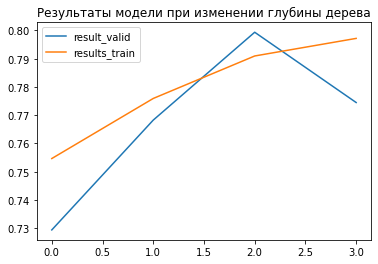

In [15]:
df_res = pd.DataFrame({'result_valid': results_valid, 'results_train': results_train})

df_res.plot(title='Результаты модели при изменении глубины дерева');

[Text(0.5, 0.875, 'X[3] <= 24925.54\ngini = 0.425\nsamples = 1928\nvalue = [1337, 591]'),
 Text(0.25, 0.625, 'X[0] <= 102.5\ngini = 0.366\nsamples = 1666\nvalue = [1265, 401]'),
 Text(0.125, 0.375, 'X[2] <= 113.5\ngini = 0.327\nsamples = 1537\nvalue = [1221, 316]'),
 Text(0.0625, 0.125, 'gini = 0.307\nsamples = 1503\nvalue = [1218, 285]'),
 Text(0.1875, 0.125, 'gini = 0.161\nsamples = 34\nvalue = [3, 31]'),
 Text(0.375, 0.375, 'X[0] <= 127.5\ngini = 0.449\nsamples = 129\nvalue = [44, 85]'),
 Text(0.3125, 0.125, 'gini = 0.496\nsamples = 94\nvalue = [43, 51]'),
 Text(0.4375, 0.125, 'gini = 0.056\nsamples = 35\nvalue = [1, 34]'),
 Text(0.75, 0.625, 'X[3] <= 29078.215\ngini = 0.399\nsamples = 262\nvalue = [72, 190]'),
 Text(0.625, 0.375, 'X[0] <= 86.5\ngini = 0.481\nsamples = 137\nvalue = [55, 82]'),
 Text(0.5625, 0.125, 'gini = 0.5\nsamples = 91\nvalue = [46, 45]'),
 Text(0.6875, 0.125, 'gini = 0.315\nsamples = 46\nvalue = [9, 37]'),
 Text(0.875, 0.375, 'X[2] <= 25.5\ngini = 0.235\nsample

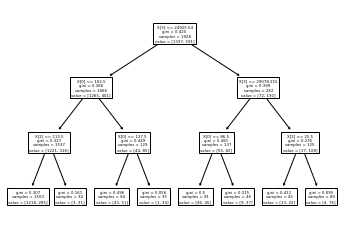

In [16]:
tree.plot_tree(best_model_dt)

In [17]:
%%time

# случайный лес
best_result = 0
best_est = 0
best_depth = 0
best_model_rf = None
for est in range(1, 11):
    for depth in range(1, 5):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth) # обучение модели с заданным количеством деревьев
        model_rf.fit(features_train, target_train) # обучение модели на тренировочной выборке
        result = model_rf.score(features_valid, target_valid) # расчет качества модели на валидационной выборке
        if result > best_result:
            best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            best_depth = depth
            best_model_rf = model_rf

print("Accuracy наилучшей модели на валидационной выборке:", best_result)
print("количество деревьев:", best_est)
print("Глубина дерева:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8102643856920684
количество деревьев: 9
Глубина дерева: 3
CPU times: total: 609 ms
Wall time: 599 ms


In [18]:
# логистическая регрессия
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) # обучение модели с заданным количеством деревьев
model_lr.fit(features_train, target_train) # обучение модели на тренировочной выборке
result = model_lr.score(features_valid, target_valid) # расчет качества модели на валидационной выборке

print("Accuracy модели на валидационной выборке:", result)
print("Максимальное количество итераций обучения:", 100)

model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) # обучение модели с заданным количеством деревьев
model_lr.fit(features_train, target_train) # обучение модели на тренировочной выборке
result = model_lr.score(features_valid, target_valid) # расчет качества модели на валидационной выборке

print("Accuracy модели на валидационной выборке:", result)
print("Максимальное количество итераций обучения:", 1000)

Accuracy модели на валидационной выборке: 0.7465007776049767
Максимальное количество итераций обучения: 100
Accuracy модели на валидационной выборке: 0.7465007776049767
Максимальное количество итераций обучения: 1000


Изменение количества итераций не ведет к улучшению точности.

In [19]:
# логистическая регрессия
param_dist = {
        'n_estimators':range(1,21)        
        }

grid = RandomizedSearchCV(RandomForestClassifier(random_state=12345),param_dist, random_state=12345, n_iter=20,n_jobs = -1)

# Тренировка на тренировочном наборе
grid.fit(features_train,target_train)
# Вернуться к лучшему тренеру
best_estimator = grid.best_estimator_
print(best_estimator)
# Вывести точность оптимального трейнера
print(grid.best_score_)
print(grid.best_params_)

RandomForestClassifier(n_estimators=18, random_state=12345)
0.7826754592557702
{'n_estimators': 18}


Accuracy наилучшей модели - случаный лес, - на валидационной выборке: 0.8102643856920684
Количество деревьев: 9, глубина дерева: 3.

Решающее дерево с глубиной 3 показывает результаты немного хуже: 0.7993779160186625

Логистическая регрессия показала наихудшие результаты и меньше целевой accuracy 0.75.

## Проверьте модель на тестовой выборке

In [20]:
result = best_model_rf.score(features_test, target_test)

print("Accuracy наилучшей модели на валидационной выборке:", result)

Accuracy наилучшей модели на валидационной выборке: 0.7947122861586314


In [21]:
result = best_model_dt.score(features_test, target_test)

print("Accuracy модели DT на валидационной выборке:", result)

Accuracy модели DT на валидационной выборке: 0.7776049766718507


Результат чуть хуже, чем на валидационной выборке, но незначительно. Решающее дерево показало результат хуже и на тестовых данных.
Объединим обучающую и валидационную выборку и обучим лучшую модель на них еще раз.

In [25]:
feature_common = pd.concat([features_valid, features_train])
feature_common.shape

(2571, 4)

In [26]:
target_common = pd.concat([target_valid, target_train])
target_common.shape

(2571,)

In [28]:
best_model_rf.fit(feature_common, target_common)

result = best_model_rf.score(features_test, target_test)

print("Accuracy наилучшей модели на валидационной выборке:", result)

Accuracy наилучшей модели на валидационной выборке: 0.7947122861586314


Результат не улучшился.

## (бонус) Проверьте модели на адекватность

Проверим модель на адекватность, используя DummyClassifier. Если результаты реальной модели будут хуже, значит, она не подходит.

In [32]:
model_d = DummyClassifier(strategy='stratified', random_state=12345)
model_d.fit(features_train, target_train)
result = model_d.score(features_test, target_test)
print(result)

0.5598755832037325


Результаты выбранной модели намного лучше, значит она адекватна.

## Чек-лист готовности проекта

Были проанализированы данные о поведении клиентов, которые уже перешли на новые тарифы Смарт и Ультра. В исходных данных есть дисбаланс распредения между тарифами: доля клиентов с тарифом Смарт выше чем доля клиентов с тарифом Ультра.

Были построены три модели для предсказывания выбора тарифа: решающее дерево, случайный лес и логистическая регрессия. Лучше всего с задачей предсказания тарифов справилась модель случайный лес с количеством деревьев 9 и глубиной дерева 3. На тестовых данных точность модели равна 0.79, что выше порогового показателя 0.75.

Модель также была проверена на адекватность, ее показания оказались намного лучше, значит она адекватна.